# **Vehicle Detection** 

***
** Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---


---

## Histogram of Oriented Gradients (HOG)

### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.



The first step in this project is to read in the KITTI and GTI Data labeled as Vehicles and Non-Vehicles:

---

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split


C:\Users\medisp\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Loading in sample images for feature extraction:

notcars = glob.glob('./non-vehicles/Extras/*.png')
notcars.extend(glob.glob('./non-vehicles/GTI/*.png'))

cars = glob.glob('./vehicles/KITTI_extracted/*.png')
cars.extend(glob.glob('./vehicles/GTI_MiddleClose/*.png')) 
cars.extend(glob.glob('./vehicles/GTI_Far/*.png')) 
cars.extend(glob.glob('./vehicles/GTI_Left/*.png')) 
cars.extend(glob.glob('./vehicles/GTI_Right/*.png')) 

'''
notcars = glob.glob('./non-vehicles_smallset/notcars1/*.jpeg')
cars = glob.glob('./vehicles_smallset/cars1/*.jpeg')
notcarsimages = glob.glob('./non-vehicles_smallset/notcars1/*.jpeg')
carsimages = glob.glob('./vehicles_smallset/cars1/*.jpeg')
cars = []
notcars = []
for image in notcarsimages:
    notcars.append(mpimg.imread(image))
for image in carsimages:
    cars.append(mpimg.imread(image))
    
'''

print('The Number of Car Samples is:', len(cars))
print('The Number of Non-Car Samples is:', len(notcars))

The Number of Car Samples is: 8481
The Number of Non-Car Samples is: 8968


The car image is: <class 'numpy.ndarray'> with dimensions: (64, 64, 3)
The non-car image is: <class 'numpy.ndarray'> with dimensions: (64, 64, 3)


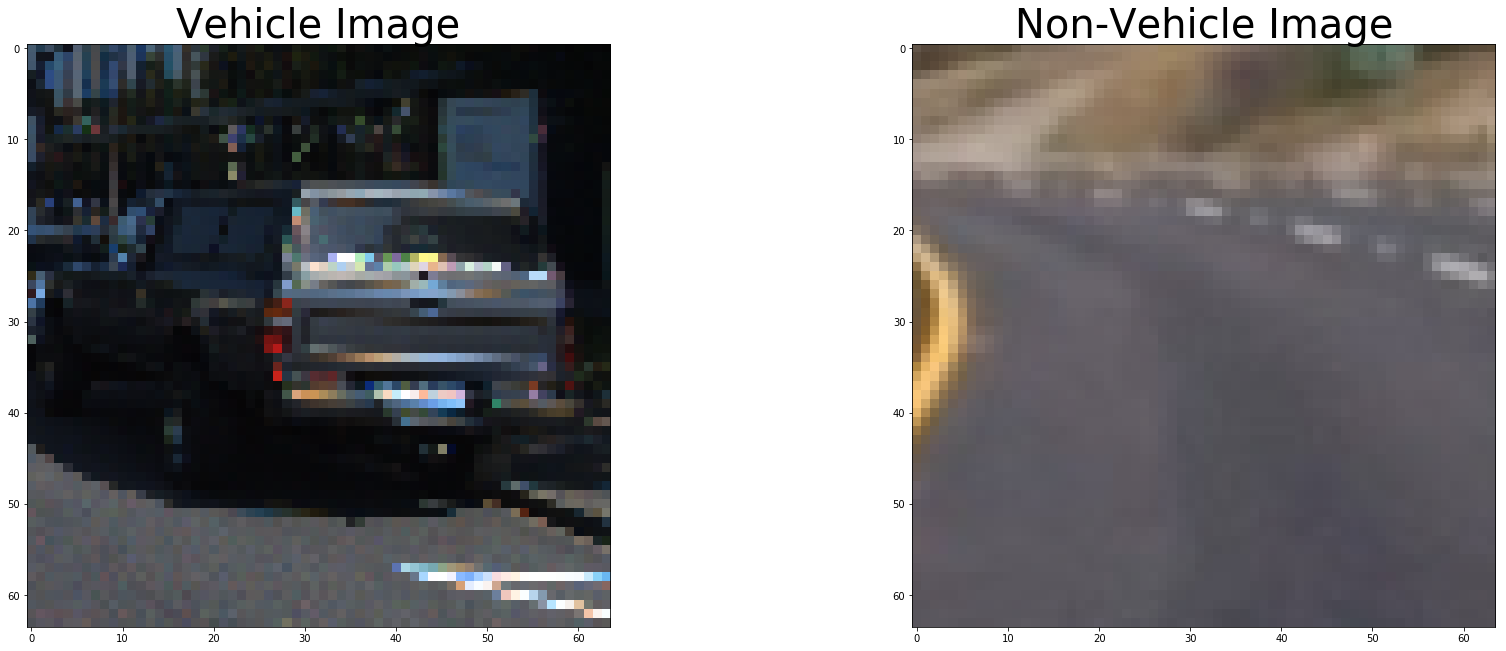

In [29]:
# Reading in the images for Car and NonCar
carimage = mpimg.imread(cars[4])
noncarimage = mpimg.imread(notcars[4])
# Printing out some stats and plotting
print('The car image is:', type(carimage), 'with dimensions:', carimage.shape)
print('The non-car image is:', type(noncarimage), 'with dimensions:', noncarimage.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(carimage)
ax1.set_title('Vehicle Image', fontsize=40)
ax2.imshow(noncarimage)
ax2.set_title('Non-Vehicle Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 1. Answer


The above shows an example of a Vehicle picture and a Non-Vehicle picture:

I experimented with changing color spaces and using skimage.hog() to get Histogram of Oriented Gradients features using 9 orientations the gradient directions can face, and 8 pixels per cell, 2 cells in each direction for a block. 


The below images show the transformation of turning to YUV color channels and using the HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

These are being stacked lengthwise and is part of the feature vectors that are used in the classifier and also what new images for classification are seen as.

---

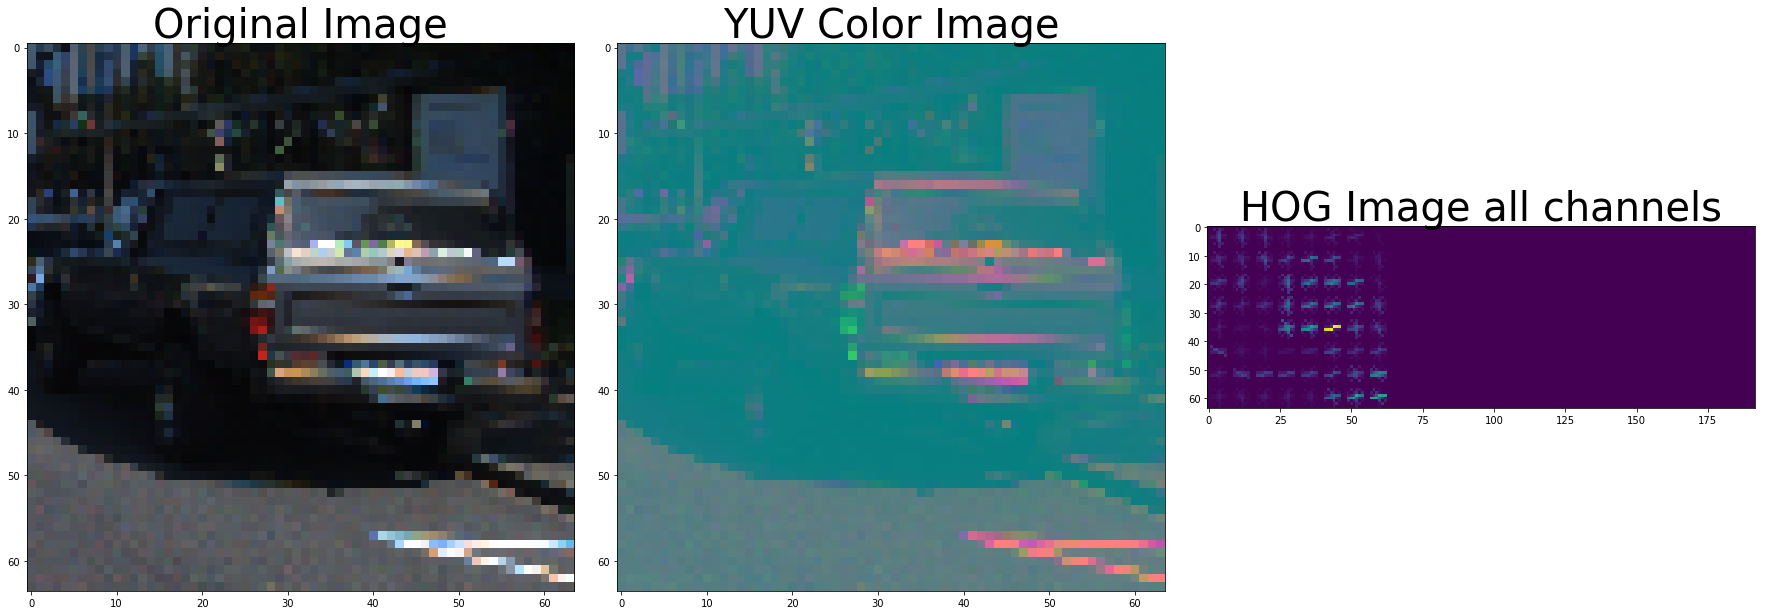

In [60]:
caryuv = cv2.cvtColor(carimage, cv2.COLOR_RGB2YUV)
testlist=[]
carhog1 = np.zeros_like(carimage[:,:,0])
carhog2 = np.zeros_like(carimage[:,:,1])
carhog3 = np.zeros_like(carimage[:,:,2])
testlist, carhog1 = get_hog_features(carimage[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
testlist, carhog = get_hog_features(carimage[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
testlist, carhog = get_hog_features(carimage[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

carhog = np.hstack((carhog1, carhog2, carhog3))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(carimage)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(caryuv)
ax2.set_title('YUV Color Image', fontsize=40)
ax3.imshow(carhog)
ax3.set_title('HOG Image all channels', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 2. Explain how you settled on your final choice of HOG parameters.

I thoroughly experimented with the accuracy of my SVM model as well as on properly detecting vehicles with many color spaces, number of orientations, pixels per cell and cells per block. I got optimal results and a trade-off of valuable features versus noise by using the configs above.

I used color features such as spatial binning and color histograms with 32,32 bins for spatial binning, and 32 histogram bins for color histogram binning. These also created extra features that assisted in the detection of cars on the video portion of the project. 

In [4]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file) #FOR PNG USING CV2 and converting to RGB
        image = cv2.imread(file)[:,:,::-1]
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [5]:
# Performing Feature Extraction:

### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' #'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [450, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        



In [6]:
# Splitting the data into training and testing
# Fit a per-column scaler  This is to normalize the different features so some large values dont dominate the model
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

---


## 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM and experimented with various parameters such as modifying C and modifying the loss parameter. Ultimately, the choice of features I extracted was the major influence on the SVM model, and I used a standard vanilla LinearSVC classifier. The code below shows commented out sections of experimentation.
Here are some statistics during training:

Using: 9 orientations 8 pixels per cell and 2 cells per block

Feature vector length: 8460

5.29 Seconds to train SVC...

Test Accuracy of SVC =  0.9937


---


In [7]:
# Classifier to test on image


print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
#svc = LinearSVC(C=3,loss='hinge')
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()




Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
5.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9937


In [ ]:
# Experimental class for collecting detections over video frames 
# Double ended queues worked more simply for me.
class Vehicle():
    def __init__(self):
        self.detected = False
        self.n_detected = 0 
        self.n_nondetected = 0
        self.xpixels = None
        self.ypixels = None
        self.recent_xfitted = []
        self.bestx = None
        self.recent_yfitted = []
        self.besty = None
        self.recent_wfitted = []
        self.bestw = None
        self.recent_hfitted = []
        self.besth = None

#carslist = []        
#carslist.append(Vehicle())        
        

---

## Sliding Window Search

## 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I gained much inspiration from the find_cars method from the lessons which is a version  of sliding windows that actually steps through the cells in a hog transformed image. This ensures that a Hog Transform is done once on each image, with cells per block 2, and pixels per cell 8. 

So each window was a translational movement of 2 cells each step, and each window was a 64 by 64 pixel area. This was more efficient than doing hog transformations on each window of the image. The code showing this implementation is as follows:

    -- Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    -- 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    -- Instead of overlap, define how many cells to step
    cells_per_step = 2  
    



---


In [47]:
img = mpimg.imread('./test_images/test1.jpg')
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,180), 6)
    # Return the image
    return img


def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    # Instead of overlap, define how many cells to step
    cells_per_step = 2  
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    global box_list
    box_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #heatmap.append()
    
    return draw_img, box_list
    
ystart = 400
ystop = 650
scale = 1.5 #1.5 #1.5

import collections
heatmaps = collections.deque(maxlen=10)
from scipy.ndimage.measurements import label    
#out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
def process_image(img):
    
    #return(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    draw_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #heat = add_heat(heat,box_list)
    current_heatmap = add_heat(heat, box_list)
    heatmaps.append(current_heatmap)
    heatmap_sum = sum(heatmaps)
    # Apply threshold to help remove false positives
    heatmap_sum = apply_threshold(heatmap_sum,8)
    # Visualize the heatmap when displaying    
    heatmap_sum = np.clip(heatmap_sum, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap_sum)
    draw_img = draw_labeled_bboxes(np.copy(draw_img), labels)
    return draw_img
    
#out_img = process_image(img)    
#plt.imshow(out_img)






---

## 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?


My final pipeline uses all channels of a YUV transformed image, and performed HOG on all channels of the image. After this, Spatially binned color histograms are also appended to the feature vector. This is an example of how rectangles are being drawn on the test image:


---


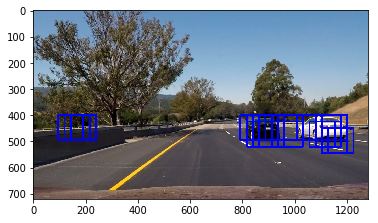

In [45]:
img = mpimg.imread('./test_images/test6.jpg')
testlist=[]
out_img,testlist = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)


---


## 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.


During detection of vehicle images, I created a list of bounding boxes that contain the areas in the image that have found a car. In this list, as the sliding window proceeded, many bounding boxes are appended to this list.

I borrowed from the lessons functions to make 3 functions, one that creates a heatmap on a black image that adds pixel intensity in all of the regions circumscribed by the bounding boxes. 

Then, a second function applies a threshold so that only pixel intensity above 8 was to be considered a valid bounding box. 

A Third function now draws a box over the original image in the locations of thresholded heatmap areas.

This got me to have fairly nice detections on cars, but tracking during the video was not sufficient, and false positives appeared frequently. 


Finally, I used a Double Ended Queues method (Inspired from the Udacity Forums/Mentors, thanks!) to keep a list of 10 heatmaps, I sum them and apply a threshold. This portion works well to keep track of previously detected vehicles and follow them in new frames. Rather than averaging the heatmap queues, I sum them and use a high threshold. This significantly minimized the number of false positives my pipeline detected and the ability to move the window and track a moving vehicle.

    heatmaps = collections.deque(maxlen=10)
    current_heatmap = add_heat(heat, box_list)
    heatmaps.append(current_heatmap)
    heatmap_sum = apply_threshold(heatmap_sum,8)
    heatmap_sum = np.clip(heatmap_sum, 0, 255)    
    
Please see below codeblock for how this was implemented:    
    
---


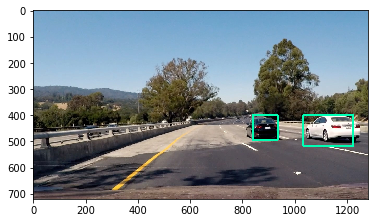

In [59]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,180), 6)
    # Return the image
    return img

import collections
heatmaps = collections.deque(maxlen=10)
from scipy.ndimage.measurements import label    
#out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
def process_image(img):
    
    #return(find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    draw_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #heat = add_heat(heat,box_list)
    current_heatmap = add_heat(heat, box_list)
    heatmaps.append(current_heatmap)
    heatmap_sum = sum(heatmaps)
    # Apply threshold to help remove false positives
    heatmap_sum = apply_threshold(heatmap_sum,8)
    # Visualize the heatmap when displaying    
    heatmap_sum = np.clip(heatmap_sum, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap_sum)
    draw_img = draw_labeled_bboxes(np.copy(draw_img), labels)
    return draw_img
    
# Read in the last image above
image = mpimg.imread('./test_images/test4.jpg')

# Display the image
plt.imshow(process_image(image))


#### The above is an example of how the heatmap functions perform in drawing bounding boxes over thresholding all boxes 

---

### Video Implementation

##  1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)


Please find a link to my project video in the github repo: Did what I could to threshold over a summed range of heatmap findings and thresholding so that cars can be tracked during movement. I am experimenting with additional color channel transformations to remove more false positives.

---


In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
white_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [12:27<00:00,  1.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

Wall time: 12min 28s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

---


## Discussion

## 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?



Overall, the approach I used closely modelled the best practices from the lessons. The takeaway things I would do to improve performance is reducing false positives by a different technique for filtering, and a more accurate model that generalizes better. My model catches fars on the other lane and when shadows are present, sometimes the ground and guard rails. 


## Things to do differently: 

Regarding Features and Training, I would try to reduce overfitting of the SVM model by increasing the number of orientations, hence the features, using only 1 color channel of YUV, and introducing additional data.
I would try a version of classes that contain Bounding Box information of the last 10+ frames and use an averaging of this for detecting the next frame's bounding boxes. This may be better than using A summing of Double Ended Queues with High Thresholding. Ultimately, making a better model that generalizes would make both of these false positive removal strategies better, so my efforts would start there.



### Recap on Project:
#### Feature Selection:
As far as features used, I converted the color scheme to 'YUV' and I appended binned color features(32 by 32 Spatial Binning), histograms of colors (Using 32 Histogram Bins) on top of the Histogram of Oriented Gradients (9 orients, 8 pixels per cell, 2 by 2 cells per block. The Feature Vector Length was 8460 elements.

#### Training:
I trained a Linear Support Vector Machines Classifier, having experimented with C and Loss parameters but ultimately, the standard settings sufficed. I trained on an 80% sample of the dataset containing 8481 Car Samples and 8968 Non-Car Samples. I normalized using ScandardScaler and Randomized the training and test data. The Final Accuracy of the SVM Model was 99.37%, though I'm sure its because there were exact match images scattered throughout the training to test datasets. This prevented better generalization of the model that would be ameliorated by using additional data or removing duplicates.

#### Sliding Window Vehicle Detection:
I used a subsampling HOG Features technique closely modeling the Lessons, whereby the windows were selections of cells that slid over 2 pixels each step and evaluated features for matching detections. This was much faster than sliding windows, though sensitive to feature changes in HOG. 

#### False Positive Removal: 
I used a heatmap on bounding box detections from the HOG subsampling technique, and kept a Double Ended Queue of 10 containing the last 10 frames. this was summed and a high threshold did well to keep out many false positive matches. ultimately, an averaging technique may be better and I'm planning to test that in the future.




---


In [ ]:
#Alternate window search function

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [ ]:
# Alternate Drawing image using the classifier
image = mpimg.imread('./test_images/test.jpg')
draw_image = np.copy(image)


windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)                    

plt.imshow(window_img)
    



**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    Rslope = []
    Lslope = []

    Llines = []
    Rlines = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            m = ((y2-y1)/(x2-x1)) # slope
            if m < 0:
                Lslope.append(m)
                Llines.append((x2,y2))
            else:
                Rslope.append(m)
                Rlines.append((x1,y1))
    
    Rslope = sorted(Rslope)[int(len(Rslope)/2)]
    Lslope = sorted(Lslope)[int(len(Lslope)/2)]

    yleft = min([line[1] for line in Llines])
    left_combined = tuple([line[0] for line in Llines if line[1] == yleft] + [yleft])

    Rleft = min([line[1] for line in Rlines])
    right_combined = tuple([line[0] for line in Rlines if line[1] == Rleft] + [Rleft])

    xleft = int((img.shape[1]-left_combined[1])/Lslope) + left_combined[0]
    xright = int((img.shape[1]-right_combined[1])/Rslope) + right_combined[0]
    
    cv2.line(img, left_combined, (xleft, img.shape[1]), color, thickness)
    cv2.line(img, right_combined, (xright, img.shape[1]), color, thickness)                      
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)